<a href="https://colab.research.google.com/github/sksizer/dat490/blob/main/LATEST_BFRSS_Exploration_KB_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup
- check env
- set and test paths for data

In [ ]:
import os
from IPython import get_ipython
import urllib.request
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

def is_colab():
    return 'google.colab' in str(get_ipython())

def download_if_needed(url: str, filename: str) -> str:
    """Download a file if it doesn't already exist."""
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        print(f"Downloaded: {filename}")
    else:
        print(f"Using cached file: {filename}")
    return filename

# Set up file paths
if is_colab():
    BFRSS_DATA_PATH = download_if_needed(
        "https://singular-eclair-6a5a16.netlify.app/LLCP2023.parquet",
        "LLCP2023.parquet"
    )
    BFRSS_CODEBOOK_PATH = download_if_needed(
        "https://singular-eclair-6a5a16.netlify.app/html/codebook_USCODE23_LLCP_021924.HTML",
        "codebook_USCODE23_LLCP_021924.HTML"
    )
else:
    BFRSS_DATA_PATH = './data/LLCP2023.parquet'
    BFRSS_CODEBOOK_PATH = './data/codebook_USCODE23_LLCP_021924.HTML'

# Check file existence
if not os.path.exists(BFRSS_DATA_PATH):
    raise FileNotFoundError(f"Data path {BFRSS_DATA_PATH} does not exist")

if not os.path.exists(BFRSS_CODEBOOK_PATH):
    raise FileNotFoundError(f"Codebook path {BFRSS_CODEBOOK_PATH} does not exist")

logger.info('Environment setup complete')





Downloaded: LLCP2023.parquet


INFO:root:Environment setup complete


Downloaded: codebook_USCODE23_LLCP_021924.HTML


# Load Data and Metadata
- creates starting DF `bfrss_raw_df` from BFRSS data
- extract metadata: parses [Codebook](https://github.com/sksizer/dat490/blob/main/data/codebook_USCODE23_LLCP_021924.HTML) into a dictionary that uses columns as keys:
  ```
  bfrss_metadata
  # to get the metadata for a column:
  bfrss_metadata['COLUMN1']

  # It also has value to value descriptions such as:
  bfrss_metadata['COLUMN1'].value_lookup[1] # will return something like 'Number of times worked out in last week'
  ```

In [ ]:
import pandas as pd
bfrss_raw_df = pd.read_parquet(BFRSS_DATA_PATH)
bfrss_raw_df.info()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433323 entries, 0 to 433322
Columns: 350 entries, _STATE to _DRNKDRV
dtypes: float64(345), object(5)
memory usage: 1.1+ GB


In [ ]:
from pydantic import BaseModel, Field
from typing import Optional
import re
from pathlib import Path
from typing import Dict
from bs4 import BeautifulSoup, PageElement


class ColumnMetadata(BaseModel):
    computed: bool
    label: str
    sas_variable_name: str
    section_name: Optional[str] = None
    section_number: Optional[int] = None
    module_number: Optional[int] = None  # Added module_number field
    question_number: Optional[int] = None
    column: Optional[str] = None  # Can be a range like "1-2" or single number
    type_of_variable: Optional[str] = None  # "Num" or "Char"
    question_prologue: Optional[str] = None
    question: Optional[str] = None
    value_lookup: dict[None | int, str] # This is a dictionary that returns the textual


def get_value_lookup(table:PageElement) -> Dict[None | int, str]:
    """
    Given one of the branch table objects, we can extract out in a fairly
    simple manner all the possible values for the target column

    Simplified table structure example:
    <table>
    <tbody>
    <tr>
    <td>value</td> (which might be a single int value, blank or could be a range
    <td>Value description
    </tr>
    </tbody>
    </table>

    :param table:
    :return:
    """
    value_dict : Dict[None | int, str] = {} # Stores the value to value description

    for tr in table.find('tbody').find_all('tr'):
        cells = tr.find_all('td')
        if len(cells) < 2:
            continue

        value_text = cells[0].text.strip()
        description = cells[1].text.strip()

        # Check if the value is actually a range such as "1 - 30" or "1-30"
        range_match = re.match(r'^(\d+)\s*[-–]\s*(\d+)$', value_text)
        if range_match:
            start = int(range_match.group(1))
            end = int(range_match.group(2))
            # Add each value in the range
            # This is kind of ugly because we are creating some value lookups
            # that have thousands of values...a function would be better but I
            # was trying to keep the metadata 'pure' data
            for i in range(start, end + 1):
                value_dict[i] = description
        else:
            # Try to parse as single integer
            try:
                value = int(value_text)
                value_dict[value] = description
            except:
                # If not a number, store as None
                value_dict[None] = description

    return value_dict

def parse_codebook_html(html_path: Path) -> Dict[str, ColumnMetadata]:
    """
    Parse the BRFSS codebook HTML file and extract column metadata.

    Args:
        html_path: Path to the HTML codebook file

    Returns:
        Dictionary mapping SAS variable names to ColumnMetadata objects
    """
    with open(html_path, 'r', encoding='windows-1252') as f:
        html_content = f.read()

    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all div elements with class "branch"
    branches = soup.find_all('div', class_='branch')

    # The first one is the Codebook header table which we don't want
    branches = branches[1:]

    metadata_dict = {}

    for branch in branches:
        # Find the table with summary="Procedure Report: Report"
        table = branch.find('table', attrs={'summary': 'Procedure Report: Report'})
        if not table:
            continue

        # Find the first td in the thead > tr
        thead = table.find('thead')
        if not thead:
            continue

        first_tr = thead.find('tr')
        if not first_tr:
            continue

        # Find td with metadata content - may not have all classes
        metadata_cell = None
        for td in first_tr.find_all('td'):
            text = td.get_text()
            if text:
                # Clean text before checking
                text_clean = text.replace('\xa0', ' ')
                if 'Label:' in text_clean and 'SAS Variable Name:' in text_clean:
                    metadata_cell = td
                    break

        if not metadata_cell:
            continue

        cell_text = metadata_cell.get_text()

        # Check if this cell contains column metadata by looking for key fields
        try:
            # Extract fields using regex - handle non-breaking spaces
            cell_text = cell_text.replace('\xa0', ' ')  # Replace non-breaking spaces

            label_match = re.search(r'Label:\s*(.+?)(?=Section\s*Name:|Core\s*Section\s*Number:|Module\s*Number:|$)', cell_text, re.DOTALL)
            section_name_match = re.search(r'Section\s*Name:\s*(.+?)(?=Core\s*Section\s*Number:|Section\s*Number:|Module\s*Number:|Question\s*Number:|$)', cell_text, re.DOTALL)
            # Handle both "Core Section Number" and "Section Number"
            section_number_match = re.search(r'(?:Core\s*)?Section\s*Number:\s*(\d+)', cell_text)
            # Handle "Module Number"
            module_number_match = re.search(r'Module\s*Number:\s*(\d+)', cell_text)
            question_number_match = re.search(r'Question\s*Number:\s*(\d+)', cell_text)
            column_match = re.search(r'Column:\s*(.+?)(?=Type\s*of\s*Variable:|$)', cell_text, re.DOTALL)
            type_match = re.search(r'Type\s*of\s*Variable:\s*(.+?)(?=SAS\s*Variable\s*Name:|$)', cell_text, re.DOTALL)
            sas_name_match = re.search(r'SAS\s*Variable\s*Name:\s*(.+?)(?=Question\s*Prologue:|Question:|$)', cell_text, re.DOTALL)
            prologue_match = re.search(r'Question\s*Prologue:\s*(.+?)(?=Question:|$)', cell_text, re.DOTALL)
            question_match = re.search(r'Question:\s*(.+?)$', cell_text, re.DOTALL)

            # Only require label and SAS variable name
            if label_match and sas_name_match:

                # Clean up the extracted values
                label = label_match.group(1).strip()
                sas_variable_name = sas_name_match.group(1).strip()

                # Extract optional fields
                section_name = section_name_match.group(1).strip() if section_name_match else None
                section_number = int(section_number_match.group(1)) if section_number_match else None
                module_number = int(module_number_match.group(1)) if module_number_match else None
                question_number = int(question_number_match.group(1)) if question_number_match else None
                column = column_match.group(1).strip() if column_match else None
                type_of_variable = type_match.group(1).strip() if type_match else None
                question_prologue = prologue_match.group(1).strip() if prologue_match else None
                question = question_match.group(1).strip() if question_match else None

                # Remove any extra whitespace or newlines
                if question_prologue and not question_prologue:
                    question_prologue = None

                # Create ColumnMetadata object
                metadata = ColumnMetadata(
                    label=label,
                    sas_variable_name=sas_variable_name,
                    section_name=section_name,
                    section_number=section_number,
                    module_number=module_number,
                    question_number=question_number,
                    column=column,
                    type_of_variable=type_of_variable,
                    question_prologue=question_prologue,
                    question=question,
                    value_lookup=get_value_lookup(table),
                    computed= True if section_name == 'Calculated Variables' or section_name == 'Calculated Race Variables' else False
                )

                metadata_dict[sas_variable_name] = metadata

        except Exception as e:
            # Skip cells that don't parse correctly but show problems
            print(e)

    return metadata_dict


bfrss_metadata = parse_codebook_html(BFRSS_CODEBOOK_PATH)

In [ ]:
# Display the number of columns parsed
print(f"Parsed {len(bfrss_metadata)} column definitions from the codebook")

# Show a sample of the metadata
sample_keys = list(bfrss_metadata.keys())[:5]
for key in sample_keys:
    metadata = bfrss_metadata[key]
    print(f"\n{key}:")
    print(f"  Label: {metadata.label}")
    print(f"  Question: {metadata.question}")
    print(f"  Column: {metadata.column}")
    print(f"  Type: {metadata.type_of_variable}")
    print(f"  Computed: {metadata.computed}")
    print(f"  Section Name: {metadata.section_name}")
    print(f"  Section Number: {metadata.section_number}")
    print(f"  Question Number: {metadata.question_number}")

Parsed 344 column definitions from the codebook

_STATE:
  Label: State FIPS Code
  Question: State FIPS Code
  Column: 1-2
  Type: Num
  Computed: False
  Section Name: Record Identification
  Section Number: 0
  Question Number: 1

FMONTH:
  Label: File Month
  Question: File Month
  Column: 17-18
  Type: Num
  Computed: False
  Section Name: Record Identification
  Section Number: 0
  Question Number: 8

IDATE:
  Label: Interview Date
  Question: Interview Date
  Column: 19-26
  Type: Char
  Computed: False
  Section Name: Record Identification
  Section Number: 0
  Question Number: 9

IMONTH:
  Label: Interview Month
  Question: Interview Month
  Column: 19-20
  Type: Char
  Computed: False
  Section Name: Record Identification
  Section Number: 0
  Question Number: 10

IDAY:
  Label: Interview Day
  Question: Interview Day
  Column: 21-22
  Type: Char
  Computed: False
  Section Name: Record Identification
  Section Number: 0
  Question Number: 11


# Metadata Documentation
Notes and examples of the metadata extraction:



In [ ]:
print(f"Total columns in dataframe: {len(bfrss_raw_df.columns)}")
print(f"Total metadata parsed: {len(bfrss_metadata)}")
print(f"Coverage: {len(bfrss_metadata) / len(bfrss_raw_df.columns) * 100:.1f}%")

# Check which columns don't have metadata
missing_metadata = [col for col in bfrss_raw_df.columns if col not in bfrss_metadata]
print(f"\nColumns without metadata: {len(missing_metadata)}")
if missing_metadata:
    print("First 10 missing:", missing_metadata[:10])
print("Note: There is data for these columns but no metadata is available, likely purged bc of policy changes.")

Total columns in dataframe: 350
Total metadata parsed: 344
Coverage: 98.3%

Columns without metadata: 7
First 10 missing: ['LNDSXBRT', 'CELSXBRT', 'BIRTHSEX', 'TRNSGNDR', 'USEMRJN4', 'RCSGEND1', 'RCSXBRTH']
Note: There is data for these columns but no metadata is available, likely purged bc of policy changes.


## Understanding the Friendly Mapping Feature
(note I generated the following docs and examples with ChatGPT, but I've vetted all of it)

The metadata parser includes a powerful "friendly mapping" feature that translates numeric codes in the dataset to their human-readable descriptions. This is particularly useful for categorical variables where numeric codes represent specific responses.

### How It Works

Each `ColumnMetadata` object contains a `value_lookup` dictionary that maps numeric values (or None) to their text descriptions. This mapping is automatically extracted from the codebook HTML file during parsing.

#### Key Components:

1. **`value_lookup` dictionary**: Found in each `ColumnMetadata` object
   - Keys: Numeric codes (int) or None
   - Values: Human-readable descriptions (str)

2. **Automatic extraction**: The `get_value_lookup()` function in `parser.py` extracts these mappings from HTML tables in the codebook

### Example 1: Understanding what values mean for a specific column

In [ ]:
# Example 1: Understanding what values mean for a specific column
# Let's look at the _STATE column which has distinct state codes

state_metadata = bfrss_metadata['_STATE']
print(f"Column: {state_metadata.sas_variable_name}")
print(f"Label: {state_metadata.label}")
print(f"Question: {state_metadata.question}")
print(f"\nSample of value mappings (first 10):")
# Show first 10 state mappings
for i, (value, description) in enumerate(state_metadata.value_lookup.items()):
    if i < 10:
        print(f"  {value}: {description}")

Column: _STATE
Label: State FIPS Code
Question: State FIPS Code

Sample of value mappings (first 10):
  1: Alabama
  2: Alaska
  4: Arizona
  5: Arkansas
  6: California
  8: Colorado
  9: Connecticut
  10: Delaware
  11: District of Columbia
  12: Florida


### Example 2: Translating values in your data

In [ ]:
# Example 2: Translating values in your data
# Let's translate some actual STATE values from the dataframe

# Get a sample of state values
sample_values = bfrss_raw_df['_STATE'].value_counts().head(10)
print("Top 10 states by number of respondents:\n")

for value, count in sample_values.items():
    # Get the description from value_lookup
    description = state_metadata.value_lookup.get(int(value) if not pd.isna(value) else None, "Unknown")
    print(f"Code {int(value)}: {description} (Count: {count:,})")

Top 10 states by number of respondents:

Code 53: Washington (Count: 26,444)
Code 36: New York (Count: 17,349)
Code 24: Maryland (Count: 17,255)
Code 27: Minnesota (Count: 16,170)
Code 39: Ohio (Count: 13,384)
Code 12: Florida (Count: 13,255)
Code 31: Nebraska (Count: 12,886)
Code 55: Wisconsin (Count: 12,819)
Code 23: Maine (Count: 12,255)
Code 4: Arizona (Count: 12,036)


### Example 3: Creating a mapping function for easy translation

In [ ]:
# Example 3: Creating a mapping function for easy translation
def translate_column_values(df, column_name, metadata_dict):
    """
    Translate numeric codes to descriptions for a specific column.

    Args:
        df: The dataframe containing the data
        column_name: Name of the column to translate
        metadata_dict: Dictionary of column metadata

    Returns:
        Pandas Series with translated values
    """
    if column_name not in metadata_dict:
        print(f"No metadata found for column: {column_name}")
        return df[column_name]

    metadata = metadata_dict[column_name]

    # Create translation function
    def translate(value):
        if pd.isna(value):
            return "Missing"
        return metadata.value_lookup.get(int(value), f"Unknown code: {value}")

    return df[column_name].apply(translate)

# Example usage - translate STATE codes
bfrss_raw_df['STATE_NAME'] = translate_column_values(bfrss_raw_df, '_STATE', bfrss_metadata)

# Show sample
print("Sample of translated state values:")
print(bfrss_raw_df[['_STATE', 'STATE_NAME']].head(10))

Sample of translated state values:
   _STATE STATE_NAME
0     1.0    Alabama
1     1.0    Alabama
2     1.0    Alabama
3     1.0    Alabama
4     1.0    Alabama
5     1.0    Alabama
6     1.0    Alabama
7     1.0    Alabama
8     1.0    Alabama
9     1.0    Alabama


### Example 4: Working with columns that have ranges

In [ ]:
# Example 4: Working with columns that have ranges
# Now let's test with POORHLTH which has a range value "1 - 30"
poorhlth_metadata = bfrss_metadata['POORHLTH']
print(f"Column: {poorhlth_metadata.sas_variable_name}")
print(f"Label: {poorhlth_metadata.label}")

# Check if the range was properly expanded
print(f"\nTotal value mappings: {len(poorhlth_metadata.value_lookup)}")
print("\nSample mappings:")
# Show some specific values to verify range expansion
for value in [1, 15, 30, 77, 88, 99]:
    if value in poorhlth_metadata.value_lookup:
        print(f"  {value}: {poorhlth_metadata.value_lookup[value]}")

Column: POORHLTH
Label: Poor Physical or Mental Health

Total value mappings: 34

Sample mappings:
  1: Number of daysNotes: _ _ Number of days
  15: Number of daysNotes: _ _ Number of days
  30: Number of daysNotes: _ _ Number of days
  77: Don't know/Not sure
  88: None
  99: Refused


### Example 5: Batch translation of multiple columns

In [ ]:
# Example 5: Batch translation of multiple columns
# This example shows how to efficiently translate multiple columns at once

def batch_translate_columns(df, column_list, metadata_dict):
    """
    Translate multiple columns from numeric codes to descriptions.

    Args:
        df: The dataframe containing the data
        column_list: List of column names to translate
        metadata_dict: Dictionary of column metadata

    Returns:
        Dictionary of translated series
    """
    translated = {}

    for col in column_list:
        if col in metadata_dict and col in df.columns:
            translated[f"{col}_DESC"] = translate_column_values(df, col, metadata_dict)
            print(f"Translated {col}")
        else:
            print(f"Skipped {col} (not found in metadata or dataframe)")

    return translated

# Translate several categorical columns
columns_to_translate = ['_STATE', 'FMONTH', 'DISPCODE', 'SEX1']
translations = batch_translate_columns(bfrss_raw_df, columns_to_translate, bfrss_metadata)

# Add translations to dataframe
for col_name, translated_series in translations.items():
    bfrss_raw_df[col_name] = translated_series

# Show sample of multiple translations
print("\nSample of translated data:")
original_cols = columns_to_translate[:3]  # Show first 3
desc_cols = [f"{col}_DESC" for col in original_cols]
print(bfrss_raw_df[original_cols + desc_cols].head())

Translated _STATE
Translated FMONTH
Translated DISPCODE
Skipped SEX1 (not found in metadata or dataframe)

Sample of translated data:
   _STATE  FMONTH  DISPCODE _STATE_DESC FMONTH_DESC        DISPCODE_DESC
0     1.0     1.0    1100.0     Alabama     January  Completed Interview
1     1.0     1.0    1100.0     Alabama     January  Completed Interview
2     1.0     1.0    1100.0     Alabama     January  Completed Interview
3     1.0     1.0    1100.0     Alabama     January  Completed Interview
4     1.0     1.0    1100.0     Alabama     January  Completed Interview


### Example 6: Getting columns by Section Name

In [ ]:
# Simple example: Get all column names for 'Calculated Variables' section
calculated_columns = [col for col, meta in bfrss_metadata.items()
                     if meta.section_name == 'Calculated Variables']

print(f"Columns in 'Calculated Variables' section: {len(calculated_columns)}")
print(f"\nColumn names: {calculated_columns}")

Columns in 'Calculated Variables' section: 70

Column names: ['_RFHLTH', '_PHYS14D', '_MENT14D', '_HLTHPL1', '_HCVU653', '_TOTINDA', 'METVL12_', 'METVL22_', 'MAXVO21_', 'FC601_', 'ACTIN13_', 'ACTIN23_', 'PADUR1_', 'PADUR2_', 'PAFREQ1_', 'PAFREQ2_', '_MINAC12', '_MINAC22', 'STRFREQ_', 'PAMISS3_', 'PAMIN13_', 'PAMIN23_', 'PA3MIN_', 'PAVIG13_', 'PAVIG23_', 'PA3VIGM_', '_PACAT3', '_PAINDX3', '_PA150R4', '_PA300R4', '_PA30023', '_PASTRNG', '_PAREC3', '_PASTAE3', '_RFHYPE6', '_CHOLCH3', '_RFCHOL3', '_MICHD', '_LTASTH1', '_CASTHM1', '_ASTHMS1', '_DRDXAR2', '_SEX', '_AGEG5YR', '_AGE65YR', '_AGE80', '_AGE_G', 'HTIN4', 'HTM4', 'WTKG3', '_BMI5', '_BMI5CAT', '_RFBMI5', '_CHLDCNT', '_EDUCAG', '_INCOMG1', '_SMOKER3', '_RFSMOK3', '_CURECI2', 'DRNKANY6', 'DROCDY4_', '_RFBING6', '_DRNKWK2', '_RFDRHV8', '_FLSHOT7', '_PNEUMO3', '_AIDTST4', '_RFSEAT2', '_RFSEAT3', '_DRNKDRV']


# Kelly Scratch

- making own copies of data for experimentation: k_df, k_metadata


In [ ]:
k_df = bfrss_raw_df.copy()
k_metadata = bfrss_metadata.copy()

# Metadata Tests
##
index = [column for column in k_metadata.keys()]
columns = [column for column in k_metadata[index[0]].model_dump().keys()]
data = []
for metadata in k_metadata.values():
    entry = []
    for column in columns:
        entry.append(metadata.model_dump()[column])
    data.append(entry)

k_m_df = pd.DataFrame(index=index, columns=columns)
k_m_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344 entries, _STATE to _DRNKDRV
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   computed           0 non-null      object
 1   label              0 non-null      object
 2   sas_variable_name  0 non-null      object
 3   section_name       0 non-null      object
 4   section_number     0 non-null      object
 5   module_number      0 non-null      object
 6   question_number    0 non-null      object
 7   column             0 non-null      object
 8   type_of_variable   0 non-null      object
 9   question_prologue  0 non-null      object
 10  question           0 non-null      object
 11  value_lookup       0 non-null      object
dtypes: object(12)
memory usage: 34.9+ KB


In [ ]:
k_m_df.head(100)

,computed,label,sas_variable_name,section_name,section_number,module_number,question_number,column,type_of_variable,question_prologue,question,value_lookup
_STATE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FMONTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IDATE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMONTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IDAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
SHINGLE2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HIVTST7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HIVTSTD3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SEATBELT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Jaime - RQ3

In [ ]:
j_df = bfrss_raw_df.copy()
j_metadata = bfrss_metadata.copy()

print(j_df.head())

   _STATE  FMONTH     IDATE IMONTH IDAY IYEAR  DISPCODE       SEQNO  \
0     1.0     1.0  03012023     03   01  2023    1100.0  2023000001   
1     1.0     1.0  01062023     01   06  2023    1100.0  2023000002   
2     1.0     1.0  03082023     03   08  2023    1100.0  2023000003   
3     1.0     1.0  03062023     03   06  2023    1100.0  2023000004   
4     1.0     1.0  01062023     01   06  2023    1100.0  2023000005   

           _PSU  CTELENM1  ...  DROCDY4_  _RFBING6  _DRNKWK2  _RFDRHV8  \
0  2.023000e+09       1.0  ...       0.0       1.0       0.0       1.0   
1  2.023000e+09       1.0  ...       0.0       1.0       0.0       1.0   
2  2.023000e+09       1.0  ...       0.0       1.0       0.0       1.0   
3  2.023000e+09       1.0  ...       0.0       1.0       0.0       1.0   
4  2.023000e+09       1.0  ...       7.0       1.0      47.0       1.0   

   _FLSHOT7  _PNEUMO3  _AIDTST4  _RFSEAT2  _RFSEAT3  _DRNKDRV  
0       2.0       2.0       2.0       1.0       1.0       9.0  


In [17]:
#Arthritis EDA

# Arthritis calculated variable info
arthritis_metadata = bfrss_metadata['_DRDXAR2']
print(f"Column: {arthritis_metadata.sas_variable_name}")
print(f"Label: {arthritis_metadata.label}")
print(f"Question: {arthritis_metadata.question}")
print(f"\nValue mappings:")
# Show arthritis mappings
for i, (value, description) in enumerate(arthritis_metadata.value_lookup.items()):
    if i < 10:
        print(f"  {value}: {description}")

#Arthritis value counts
sample_values = bfrss_raw_df['_DRDXAR2'].value_counts().head(10)
print("\nArthritis category counts:")

for value, count in sample_values.items():
    # Get the description from value_lookup
    description = arthritis_metadata.value_lookup.get(int(value) if not pd.isna(value) else None, "Unknown")
    print(f"Code {int(value)}: {description} (Count: {count:,})")

Column: _DRDXAR2
Label: Respondents diagnosed with arthritis
Question: Respondents who have had a doctor diagnose them as having some form of arthritis

Value mappings:
  1: Diagnosed with arthritisNotes: HAVARTH4=1
  2: Not diagnosed with arthritisNotes: HAVARTH4=2
  None: Don't know/Not Sure/Refused/MissingNotes: HAVARTH4=7,9, or missing

Arthritis category counts:
Code 2: Not diagnosed with arthritisNotes: HAVARTH4=2 (Count: 287,999)
Code 1: Diagnosed with arthritisNotes: HAVARTH4=1 (Count: 142,764)


In [ ]:
# List of Variable Names in Category: Chronic Health Conditions
chronic_health_conditions_columns = [col for col, meta in bfrss_metadata.items()
                     if meta.section_name == 'Chronic Health Conditions']

print(f"Columns in 'Chronic Health Conditions' section: {len(chronic_health_conditions_columns)}")
print(f"\nColumn names: {chronic_health_conditions_columns}")

Columns in 'Chronic Health Conditions' section: 13

Column names: ['CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'DIABAGE4']


In [ ]:
# List of Variable Names in Category: Demographics
demographics_columns = [col for col, meta in bfrss_metadata.items()
                        if 'Demographics' in meta.section_name]

print(f"Columns in 'Demographics' section: {len(demographics_columns)}")
print(f"\nColumn names: {demographics_columns}")

Columns in 'Demographics' section: 13

Column names: ['MARITAL', 'EDUCA', 'RENTHOM1', 'NUMHHOL4', 'NUMPHON4', 'CPDEMO1C', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME3', 'PREGNANT', 'WEIGHT2', 'HEIGHT3']


In [ ]:
# Print column names that contain 'FMONTH'
matching_columns = [col for col in bfrss_raw_df.columns if 'FMONTH' in col]
print("Columns containing 'FMONTH':", matching_columns)

# Optionally: show first few values if column exists
if matching_columns:
    print("\nSample values:")
    print(bfrss_raw_df[matching_columns].head())



# Print column names that contain 'DISPCODE'
matching_columns = [col for col in bfrss_raw_df.columns if 'DISPCODE' in col]
print("Columns containing 'DISPCODE':", matching_columns)

# Optionally: show first few values if column exists
if matching_columns:
    print("\nSample values:")
    print(bfrss_raw_df[matching_columns].head())


Columns containing 'FMONTH': ['FMONTH']

Sample values:
   FMONTH
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
Columns containing 'DISPCODE': ['DISPCODE']

Sample values:
   DISPCODE
0    1100.0
1    1100.0
2    1100.0
3    1100.0
4    1100.0


In [ ]:
# Demographics EDA

# Issue, seems not all calculated variables are mapped, because those with Column name == 'Demographics' is only 13, but contains 'Demographics' is 344. Need to access metadata of calculated variables like _AGE5YR and _MRACE1

# Ensure keys in bfrss_metadata are strings, and filter based on section_name
demographics_columns = [
    col for col, meta in bfrss_metadata.items()
    if isinstance(col, str) and hasattr(meta, 'section_name') and 'Demographics' in meta.section_name
]

print(f"Columns in 'Demographics' section: {len(demographics_columns)}")
print(f"\nColumn names: {demographics_columns}")

# Loop through demographic variables and print metadata
for var in demographics_columns:
    meta = bfrss_metadata[var]
    print(f"\n=== Column: {meta.sas_variable_name} ===")
    print(f"Label: {meta.label}")
    print(f"Question: {meta.question}")

# Restrict to a specific list of demographic variables (the ones associated with socioeconomic status)
demographics_columns = ['EDUCA', 'EMPLOY1', 'INCOME3']

# Loop through demographic variables
for demographics_variable in demographics_columns:
    metadata = bfrss_metadata[demographics_variable]

    print(f"\n=== Column: {metadata.sas_variable_name} ===")
    print(f"Label: {metadata.label}")
    print(f"Question: {metadata.question}")

    print("\nValue mappings:")
    for i, (value, description) in enumerate(metadata.value_lookup.items()):
        if i < 10:
            print(f"  {value}: {description}")

    # Demographics_variable value counts
    sample_values = bfrss_raw_df[demographics_variable].value_counts().head(10)
    print(f"\n{metadata.sas_variable_name} category counts:")

    for value, count in sample_values.items():
        if pd.notna(value):
            try:
                lookup_key = int(value)
            except ValueError:
                lookup_key = value
        else:
            lookup_key = None

        description = metadata.value_lookup.get(lookup_key, "Unknown")
        print(f"  Code {value}: {description} (Count: {count:,})")

Columns in 'Demographics' section: 13

Column names: ['MARITAL', 'EDUCA', 'RENTHOM1', 'NUMHHOL4', 'NUMPHON4', 'CPDEMO1C', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME3', 'PREGNANT', 'WEIGHT2', 'HEIGHT3']

=== Column: MARITAL ===
Label: Marital Status
Question: Are you: (marital status)

=== Column: EDUCA ===
Label: Education Level
Question: What is the highest grade or year of school you completed?

=== Column: RENTHOM1 ===
Label: Own or Rent Home
Question: Do you own or rent your home?

=== Column: NUMHHOL4 ===
Label: Household Landline Telephones
Question: Not including cell phones or numbers used for computers, fax machines or security systems, do you have more than one landline telephone number in your household?

=== Column: NUMPHON4 ===
Label: Residential Landline Phones
Question: How many of these landline telephone numbers are residential numbers?

=== Column: CPDEMO1C ===
Label: Do you have a cell phone for your personal use?
Question: How many cell phones do you have for your p

<ipython-input-23-38ea17656a63>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=labels, orient='h', palette='viridis')


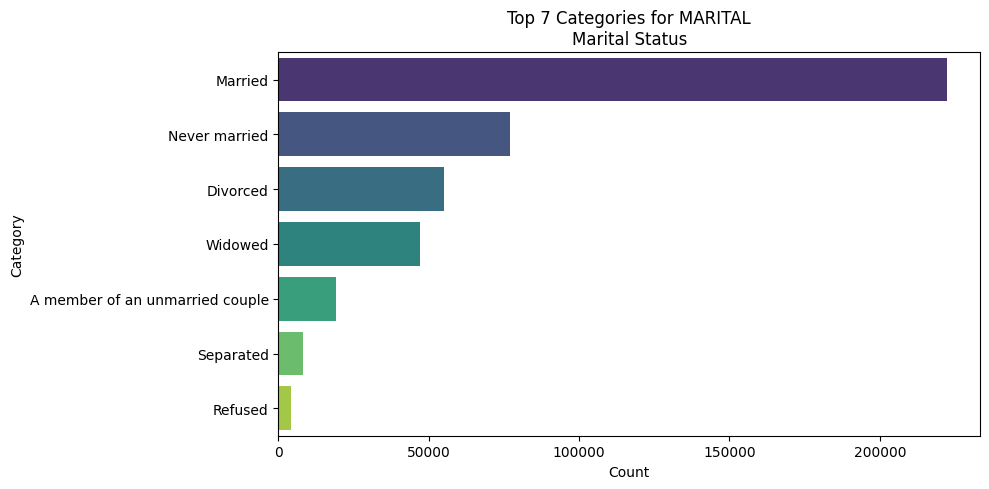

<ipython-input-23-38ea17656a63>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=labels, orient='h', palette='viridis')


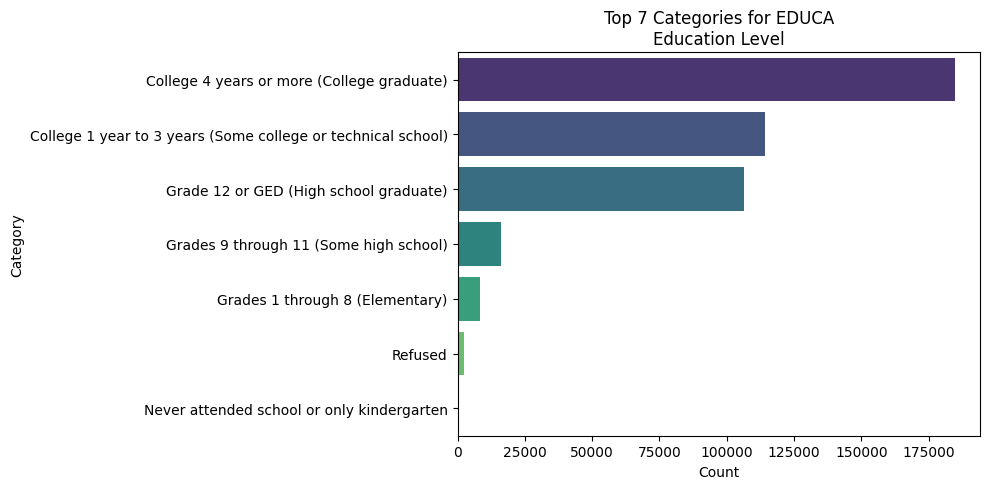

<ipython-input-23-38ea17656a63>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=labels, orient='h', palette='viridis')


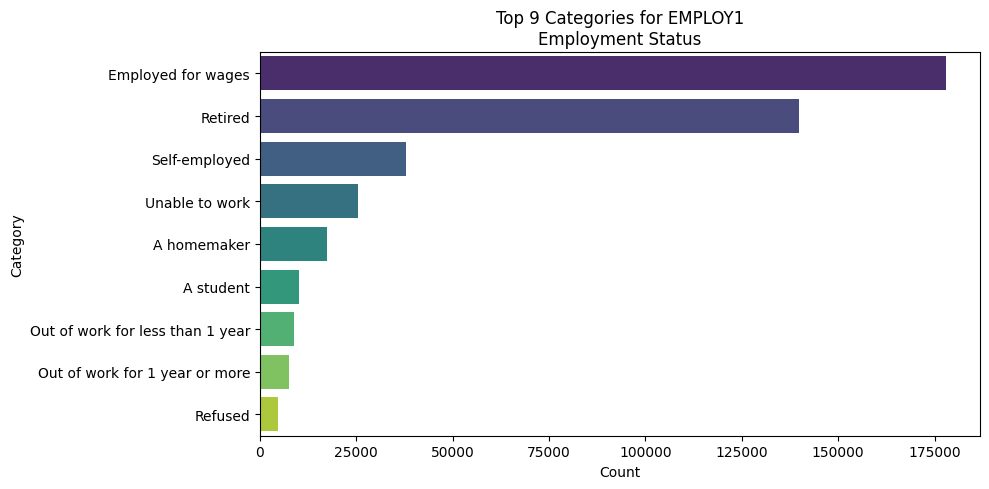

<ipython-input-23-38ea17656a63>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=labels, orient='h', palette='viridis')


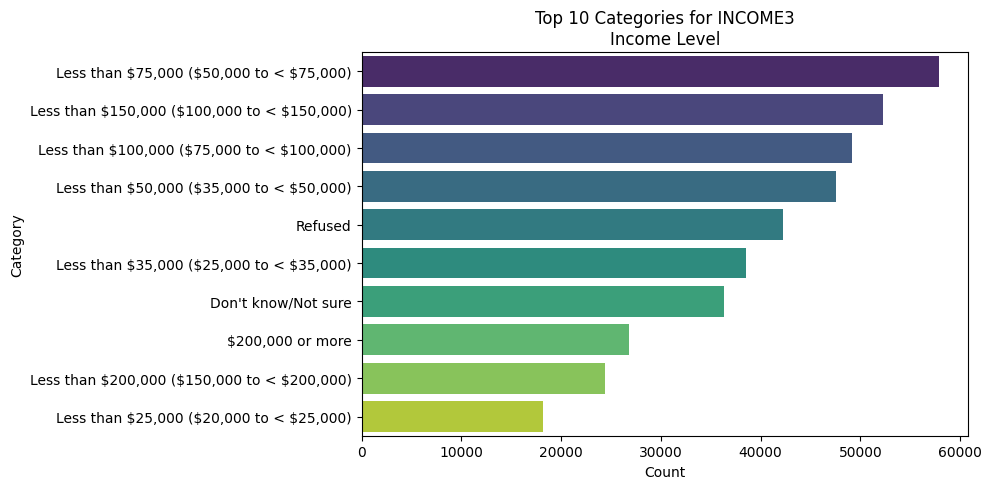

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Demographics Bar Charts

# Restrict to a specific list of demographic variables
demographics_columns = ['MARITAL', 'EDUCA', 'EMPLOY1', 'INCOME3']

for demographics_variable in demographics_columns:
    metadata = bfrss_metadata[demographics_variable]
    col_values = bfrss_raw_df[demographics_variable].dropna()

    # Map code to label for top 10 value counts
    value_counts = col_values.value_counts().head(10)
    labels = [metadata.value_lookup.get(int(val), f"Code {val}") for val in value_counts.index]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=value_counts.values, y=labels, orient='h', palette='viridis')
    plt.title(f"Top {len(labels)} Categories for {metadata.sas_variable_name}\n{metadata.label}")
    plt.xlabel("Count")
    plt.ylabel("Category")
    plt.tight_layout()
    plt.show()


<ipython-input-14-8a73bc2cd09f>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ordered_counts, y=ordered_labels, orient='h', palette=palette)


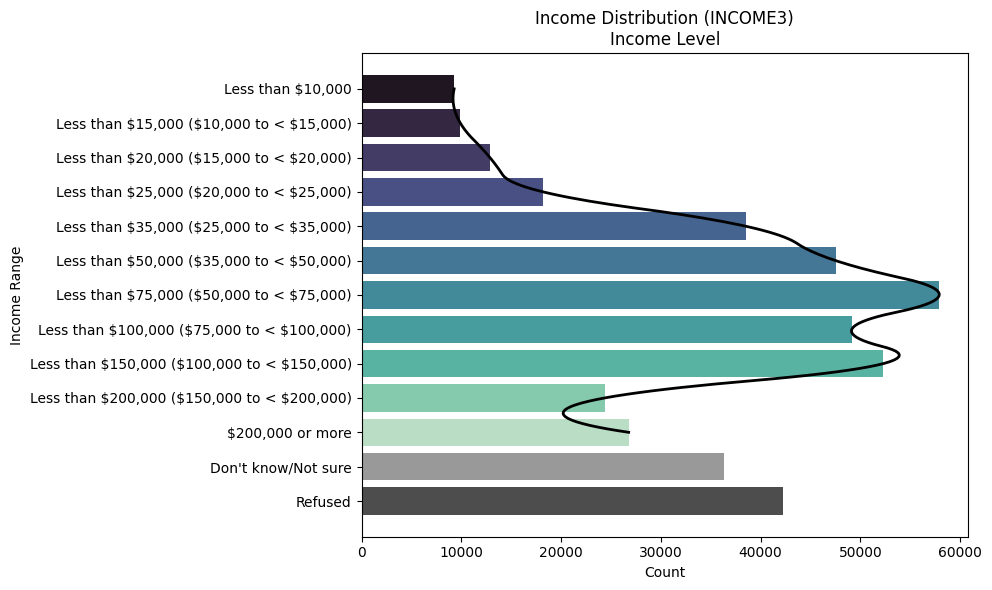

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline

# INCOME3-specific visualization in logical income order
metadata = bfrss_metadata['INCOME3']
income_series = bfrss_raw_df['INCOME3'].dropna()

# Define the intended logical income order manually
ordered_codes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 77, 99]
ordered_labels = [metadata.value_lookup.get(code, f"Code {code}") for code in ordered_codes]
counts = income_series.value_counts()

# Extract counts for codes in the desired order (skip codes not in data)
ordered_counts = [counts.get(code, 0) for code in ordered_codes]

# Custom colors: grays for 77 and 99, color palette for others
main_palette = sns.color_palette("mako", len(ordered_codes) - 2)
palette = main_palette + [(0.6, 0.6, 0.6), (0.3, 0.3, 0.3)]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=ordered_counts, y=ordered_labels, orient='h', palette=palette)

# Smooth line over the main income groups (exclude 77 and 99)
x_vals = np.array(ordered_counts[:-2])
y_vals = np.array(range(len(ordered_counts) - 2))

# Fit a spline for smoothing
if len(x_vals) > 3:
    spline = make_interp_spline(y_vals, x_vals, k=2)
    y_smooth = np.linspace(y_vals.min(), y_vals.max(), 200)
    x_smooth = spline(y_smooth)
    plt.plot(x_smooth, y_smooth, color='black', linewidth=2)

plt.title(f"Income Distribution ({metadata.sas_variable_name})\n{metadata.label}")
plt.xlabel("Count")
plt.ylabel("Income Range")
plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.formula.api as smf

# Demographic and health condition variables
demographics = ['EDUCA', 'EMPLOY1', 'INCOME3', '_RACE']
conditions = ['MICHD', 'ASTHMS1', '_DRDXAR2']

# Loop through each condition and run a logistic regression on all demographics
for cond in conditions:
    if cond in bfrss_raw_df.columns:
        # Build formula
        predictors = ' + '.join([d for d in demographics if d in bfrss_raw_df.columns])
        formula = f"{cond} ~ {predictors}"

        # Subset and clean data
        model_data = bfrss_raw_df[[cond] + demographics].dropna()
        for col in demographics:
            model_data[col] = model_data[col].astype('category')

        # Fit logistic regression
        try:
            model = smf.logit(formula=formula, data=model_data).fit(disp=False)
            print(f"\n=== Logistic Regression Results for {cond} ===")
            print(model.summary2().tables[1])
        except Exception as e:
            print(f"Could not fit model for {cond}: {e}")


Could not fit model for _DRDXAR2: endog must be in the unit interval.
